# Imports

In [351]:
# SKLearn
import sklearn
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import svm
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

import skimage
from skimage.feature import hog

# MatPlotLib
import matplotlib.pyplot as plt
%matplotlib inline

# The rest
import numpy as np
from scipy.ndimage.measurements import label
import cv2
import glob
import csv

# Data Loading - Config

In [352]:
DATASET_DIR = "../datasets/object-detection-crowdai"
NUM_ROWS_TO_LOAD = 500
SAMPLE_SHAPE = (64, 64)

# Data Loading

In [353]:
dataset_rows = []

# Load labels
with open(DATASET_DIR + '/labels.csv', 'r') as csvfile:
    # Override field names, they are incorrect in the head of labels.csv
    fieldnames = 'xmin', 'ymin', 'xmax', 'ymax', 'frame', 'label', 'preview_url'
    reader = csv.DictReader(csvfile, fieldnames, delimiter=',', quotechar='|')
    # Skip incorrect header line
    next(reader)
    for row in reader:
        dataset_rows.append(row)

def get_car_rows(dataset_rows, count):
    rows = [row for row in dataset_rows if row['label'] == 'Car']  # Note: we ignore trucks as cars
    return rows[0:count]
    # TODO: If we want to skip adjancent frames, now is the time
    # sorted_car_rows = sorted(car_rows, key=lambda row: int(row['Frame'].split('.')[0])

def get_non_car_rows(dataset_rows, count):
    rows = [row for row in dataset_rows if row['label'] != 'Car' and row['label'] != 'Truck'] # Note we don't want trucks too
    return rows[0:count]



car_rows = get_car_rows(dataset_rows, NUM_ROWS_TO_LOAD)
non_car_rows = get_non_car_rows(dataset_rows, NUM_ROWS_TO_LOAD)

# print('Car example: ', car_rows[50], "\n")
# print('Non-car example: ', non_car_rows[50], "\n")

def get_image_by_frame(frame_name):
    return cv2.imread(DATASET_DIR + '/' + frame_name)

def get_fixed_size_sample_by_row(row, size):
    img = get_image_by_frame(row['frame'])
    
    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    xmax = int(row['xmax'])
    ymax = int(row['ymax'])

    sample = img[ymin:ymax, xmin:xmax]
    return cv2.resize(sample, size)

print("Loading images...")
car_images = [get_fixed_size_sample_by_row(row, SAMPLE_SHAPE) for row in car_rows]
non_car_images = [get_fixed_size_sample_by_row(row, SAMPLE_SHAPE) for row in non_car_rows]

print("Images loaded!\n")
# sample = get_fixed_size_sample_by_row(car_rows[70], SAMPLE_SHAPE)
# plt.imshow(sample)

Loading images...
Images loaded!



### Important Note

While loading, we need to make sure that consistent color scheme and pixel range is used. 
matplotlib has various conventions, perhaps it's better to just use cv2.imread?

# Feature extraction - Config

In [354]:
TARGET_COLOR_SPACE = cv2.COLOR_RGB2HLS
CHIST_BINS = 32
CVEC_SHAPE=(32,32)
HOG_PIXELS_PER_CELL=(8,8)
HOG_CELLS_PER_BLOCK=(2,2)
HOG_ORIENTATIONS=9
SEARCH_C_VALUES=[1, 10, 100]
SEARCH_KERNEL_VALUES=['rbf'] # Linear kernel never performed best in my tests, so I don't try them
SEARCH_GAMMA_VALUES=[0.001, 0.0001]

# Feature Extraction

In [357]:
def image_to_feature(image, skip_color_convert=False):
    features_arr = []
    # assert that size is correct and that range is 0-255
    assert image.shape == (SAMPLE_SHAPE[0], SAMPLE_SHAPE[1], 3)
    # normalize the image 
    # TODO
#     image = preprocessing.scale(image)
    # convert color space 
    if not skip_color_convert:
        image = cv2.cvtColor(image, TARGET_COLOR_SPACE)
    # extract space-invariant color information (histogram). ignore centers.
    ch1_hist, _ = np.histogram(image[:,:,0], bins=CHIST_BINS, range=(0,256))
    ch2_hist, _ = np.histogram(image[:,:,1], bins=CHIST_BINS, range=(0,256))
    ch3_hist, _ = np.histogram(image[:,:,2], bins=CHIST_BINS, range=(0,256))
    features_arr.append(ch1_hist)
    features_arr.append(ch2_hist)
    features_arr.append(ch3_hist)
    # extract space-variant color information (flattened, downsampled bins)
    color_bin_features = cv2.resize(image, CVEC_SHAPE).ravel()
    features_arr.append(color_bin_features)
    # extract color-invariant shape information (histogram of gradients)
    hog_features = hog(image[:,:,0], 
                                 orientations=HOG_ORIENTATIONS,
                                 pixels_per_cell=HOG_PIXELS_PER_CELL,
                                 cells_per_block=HOG_CELLS_PER_BLOCK,
                                 visualise=False,
                                 feature_vector=True)
    features_arr.append(hog_features)
#     scaled_feat_arr = [preprocessing.scale(feature.astype(np.float64)) for feature in features_arr]
#     features = np.concatenate(scaled_feat_arr)
#   return features
    return features_arr
    
    

# Training and Scoring Pipeline

In [360]:
# Iamge to features
car_features = [image_to_feature(img) for img in car_images]
non_car_features = [image_to_feature(img) for img in non_car_images]
print("Feature extraction complete\n")
car_features = StandardScaler().fit(car_features, axis=1).transform(car_features, axis=1)


# Create training features array and labels
features = np.vstack((car_features, non_car_features))
# normalize joined features
features = StandardScaler().fit(features).transform(features)

car_labels = np.ones(len(car_features))
non_car_labels = np.zeros(len(non_car_features))
labels = np.hstack((car_labels, non_car_labels))

# Shuffle data and split into training, test
rand_state = 10 # Something consistent
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=rand_state)

# Start training and parameter search
parameters = {'kernel': SEARCH_KERNEL_VALUES, 'C': SEARCH_C_VALUES, 'gamma': SEARCH_GAMMA_VALUES}
clf = GridSearchCV(svm.SVC(), parameters)
print("Starting training... \n")
clf.fit(X_train, y_train)
print("Training complete\n")

# Report best parameters and accuracy
optimal_params = clf.best_params_
print("Optimal parameters found: ", optimal_params, "\n")
test_score = clf.score(X_test, y_test)
print("Test score: ", test_score, "\n")


Feature extraction complete



TypeError: fit() got an unexpected keyword argument 'axis'

# Save the classifier if we're happy with it

In [180]:
# Save the classifier
joblib.dump(clf, 'intermediates/car_classifier' + str(validation_score) + '.pkl', compress=9)
print("Classifier saved\n")

Classifier saved



---

# Load Saved Classifier

In [334]:
clf = joblib.load("intermediates/car_classifier0.94.pkl")

# Sliding Windows - Config

In [347]:
WINDOW_SEARCH_RANGES = [
#     {'window_size': (256,256), 'x_start_stop': [None, None], 'y_start_stop': [360, 740], 'xy_overlap':(0.8, 0.8)},
#     {'window_size': (192,192), 'x_start_stop': [None, None], 'y_start_stop': [360, 740], 'xy_overlap':(0.8, 0.8)},
    {'window_size': (128,128), 'x_start_stop': [50, 1300], 'y_start_stop': [360, 600], 'xy_overlap':(0.5, 0.5)},
#     {'window_size': (64,64), 'x_start_stop': [200, 1200], 'y_start_stop': [360, 500], 'xy_overlap':(0.5, 0.5)},
]
DETECTION_THRESHOLD = 2

# Sliding Window

In [348]:
# Attribution - code from lesson
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Process single image

In [349]:
 # Calculates all sliding windows according to our WINDOW_SEARCH_RANGES
def get_all_windows(image):
    all_windows = []
    for search_range in WINDOW_SEARCH_RANGES:
        windows = slide_window(image, 
                               xy_window=search_range['window_size'],
                               x_start_stop=search_range['x_start_stop'], 
                               y_start_stop=search_range['y_start_stop'], 
                               xy_overlap=search_range['xy_overlap'])
        all_windows.extend(windows)
    return all_windows

def draw_rectangles(image, rectangles, color=(255,0,0), thickness=5):
    for rec in rectangles:
        cv2.rectangle(image, rec[0], rec[1], color=color, thickness=thickness)
    return image

def classify_windows(image, windows):
    # Convert to our target color space
    cvt_image = cv2.cvtColor(image, TARGET_COLOR_SPACE)

    # Precompute HOG features (keep result in 2d)
    hog_features = hog(cvt_image[:,:,0], 
                             orientations=HOG_ORIENTATIONS,
                             pixels_per_cell=HOG_PIXELS_PER_CELL,
                             cells_per_block=HOG_CELLS_PER_BLOCK,
                             visualise=False,
                             feature_vector=False)
    # Go over each window, and check for detection. Save the windows with detectiosn
    positive_windows = []
    for window in windows:
        xmin = window[0][0]
        ymin = window[0][1]
        xmax = window[1][0]
        ymax = window[1][1]
        window_img = image[ymin:ymax, xmin:xmax]
        if window_img.shape[0:2] != SAMPLE_SHAPE:
            window_img = cv2.resize(window_img, SAMPLE_SHAPE)

        features = image_to_feature(window_img, skip_color_convert=True)

        res = clf.predict(features.reshape(1, -1))

        if res == 1:
            positive_windows.append(window)
            
    # Return the positive classifications
    return positive_windows


def heatmap_from_positives(image, positive_windows):
    heatmap = np.zeros(image.shape[0:2])
    for window in positive_windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

# Attribution - adapted from lesson to return rather than display the bounding boxes
def get_labeled_bboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)

    # Return the found bounding boxes
    return bboxes

def process_image(image):
    # Get sliding windows
    windows = get_all_windows(image)
    # Classify
    positive_windows = classify_windows(image, windows)
    # Turn into heatmap
    heatmap = heatmap_from_positives(image, positive_windows)
    heatmap_orig = np.copy(heatmap)
    # Threshold
    heatmap[heatmap <= DETECTION_THRESHOLD] = 0
    # Label separate detections
    labels = label(heatmap)
    # Calculate bounding boxes for labels
    detected_bboxes = get_labeled_bboxes(labels)
    
    return detected_bboxes, windows, positive_windows, heatmap_orig, heatmap, labels

    
def visualise_process_for_image(path):
    image = cv2.imread(path)
    detected_bboxes, scanned_windows, positive_windows, heatmap_orig, heatmap, labels = process_image(image)

    # Draw detections
    img_with_detections = np.copy(image)
    img_with_detections = draw_rectangles(img_with_detections, detected_bboxes)

    # Draw scanned_windows
    img_with_scans = np.copy(image)
    img_with_scans = draw_rectangles(img_with_scans, scanned_windows)

    # Draw positive scanned_windows
    img_with_positive_scans = np.copy(image)
    img_with_positive_scans = draw_rectangles(img_with_positive_scans, positive_windows)

    # Visualize
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))
    f.tight_layout()
    plt.suptitle("Example steps", fontsize=50)
    ax1.set_title('Detections', fontsize=30)
    ax1.imshow(img_with_detections)
    ax2.set_title('Scanned Windows', fontsize=30)
    ax2.imshow(img_with_scans)
    ax3.set_title('Positive Scans', fontsize=30)
    ax3.imshow(img_with_positive_scans)
    ax4.set_title('Heatmap before threshold', fontsize=30)
    ax4.imshow(heatmap_orig, cmap='gray')
    ax5.set_title('Heatmap after threshold', fontsize=30)
    ax5.imshow(heatmap, cmap='gray')
    ax6.set_title('Labels', fontsize=30)
    ax6.imshow(labels[0], cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)
    plt.show()
    

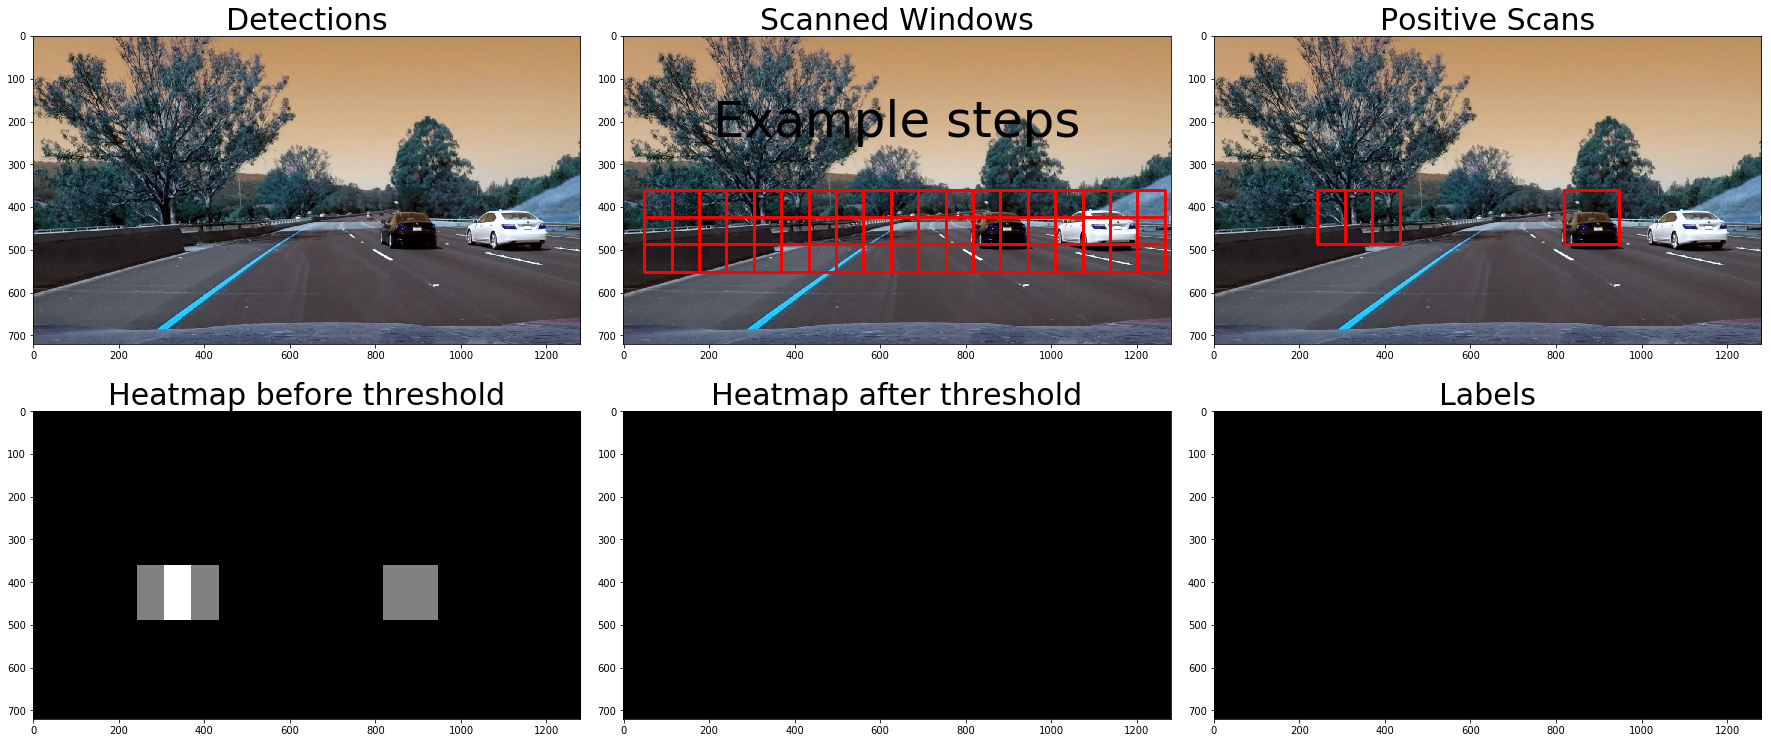

In [350]:
visualise_process_for_image('test_images/test6.jpg')

# Last part - Perform the detection over a video